# RECTE Demonstrations with TRAPPIST-1 Observations
This Jupyter notebook demonstrates how to use RECTE to remove ramp effect systematics in the HST/WFC3 light curves. We apply RECTE correction to the TRAPPIST-1 observations (firstly published in De Wit et al. 2016). Results in this demosntration were published in Zhang et al. (2018).

## Light curve Preparations
The light curve for each wavelength channel needs to be extracted from the observation ima frame before applying the RECTE correction (or any other types of ramp effect correction). The reference for this procedures is Deming et al. (2013). Light curves were pre-calculated for this demonstration and stored in  a python shelve file. 

We first plot the extracted light curves, without applying any correction. The characteristic ramp is visible in every light curve. These ramps have stronger amplitude at the first orbits of the observations. We can see some other features in these ligth curves:  
1. Except for the first orbit light curves, the HST-orbital-variations of the ramp systematics are still visible. Comparing the light curves for the second orbit and that for the last orbit, the ramp amplitudes for the second orbit are stronger. This features shows the process of charge trapping lasting through the entire observations, especially for a faint host star such as TRAPPIST-1.
2. Channel-variation of the the ramp systematics are also visible. TRAPPIST-1, being an M8 star, has a signficant 1.4 $\mu$m water feature in its 1.1 to 1.7 $\mu$m spectrum. This water feature introduces flux intensity variations between channels. From the charge trapping perspective, flux intensity variations lead to different charge trapping rate between different channels, and thus differnt ramp profiles.
RECTE model considers these aspects in the corrections and provides a physically-motivated solution.

## Uncorrected light curves

In [3]:
import shelve
import matplotlib.pyplot as plt
import pickle
import numpy as np
%matplotlib notebook

In [5]:
# First, restore light curve array from the shelve file
DBFileName = './demonstration_data/binned_lightcurves_visit_01.pickle'
with open(DBFileName, 'rb') as pkl:
    saveDB = pickle.load(pkl)
LCarray = saveDB['LCmat']
ERRarray = saveDB['Errmat']
time = saveDB['time']
wavelength = saveDB['wavelength']
orbit = saveDB['orbit']
orbit_transit = np.array([2])  # transit occurs in the third orbits
expTime = saveDB['expTime']

<IPython.core.display.Javascript object>


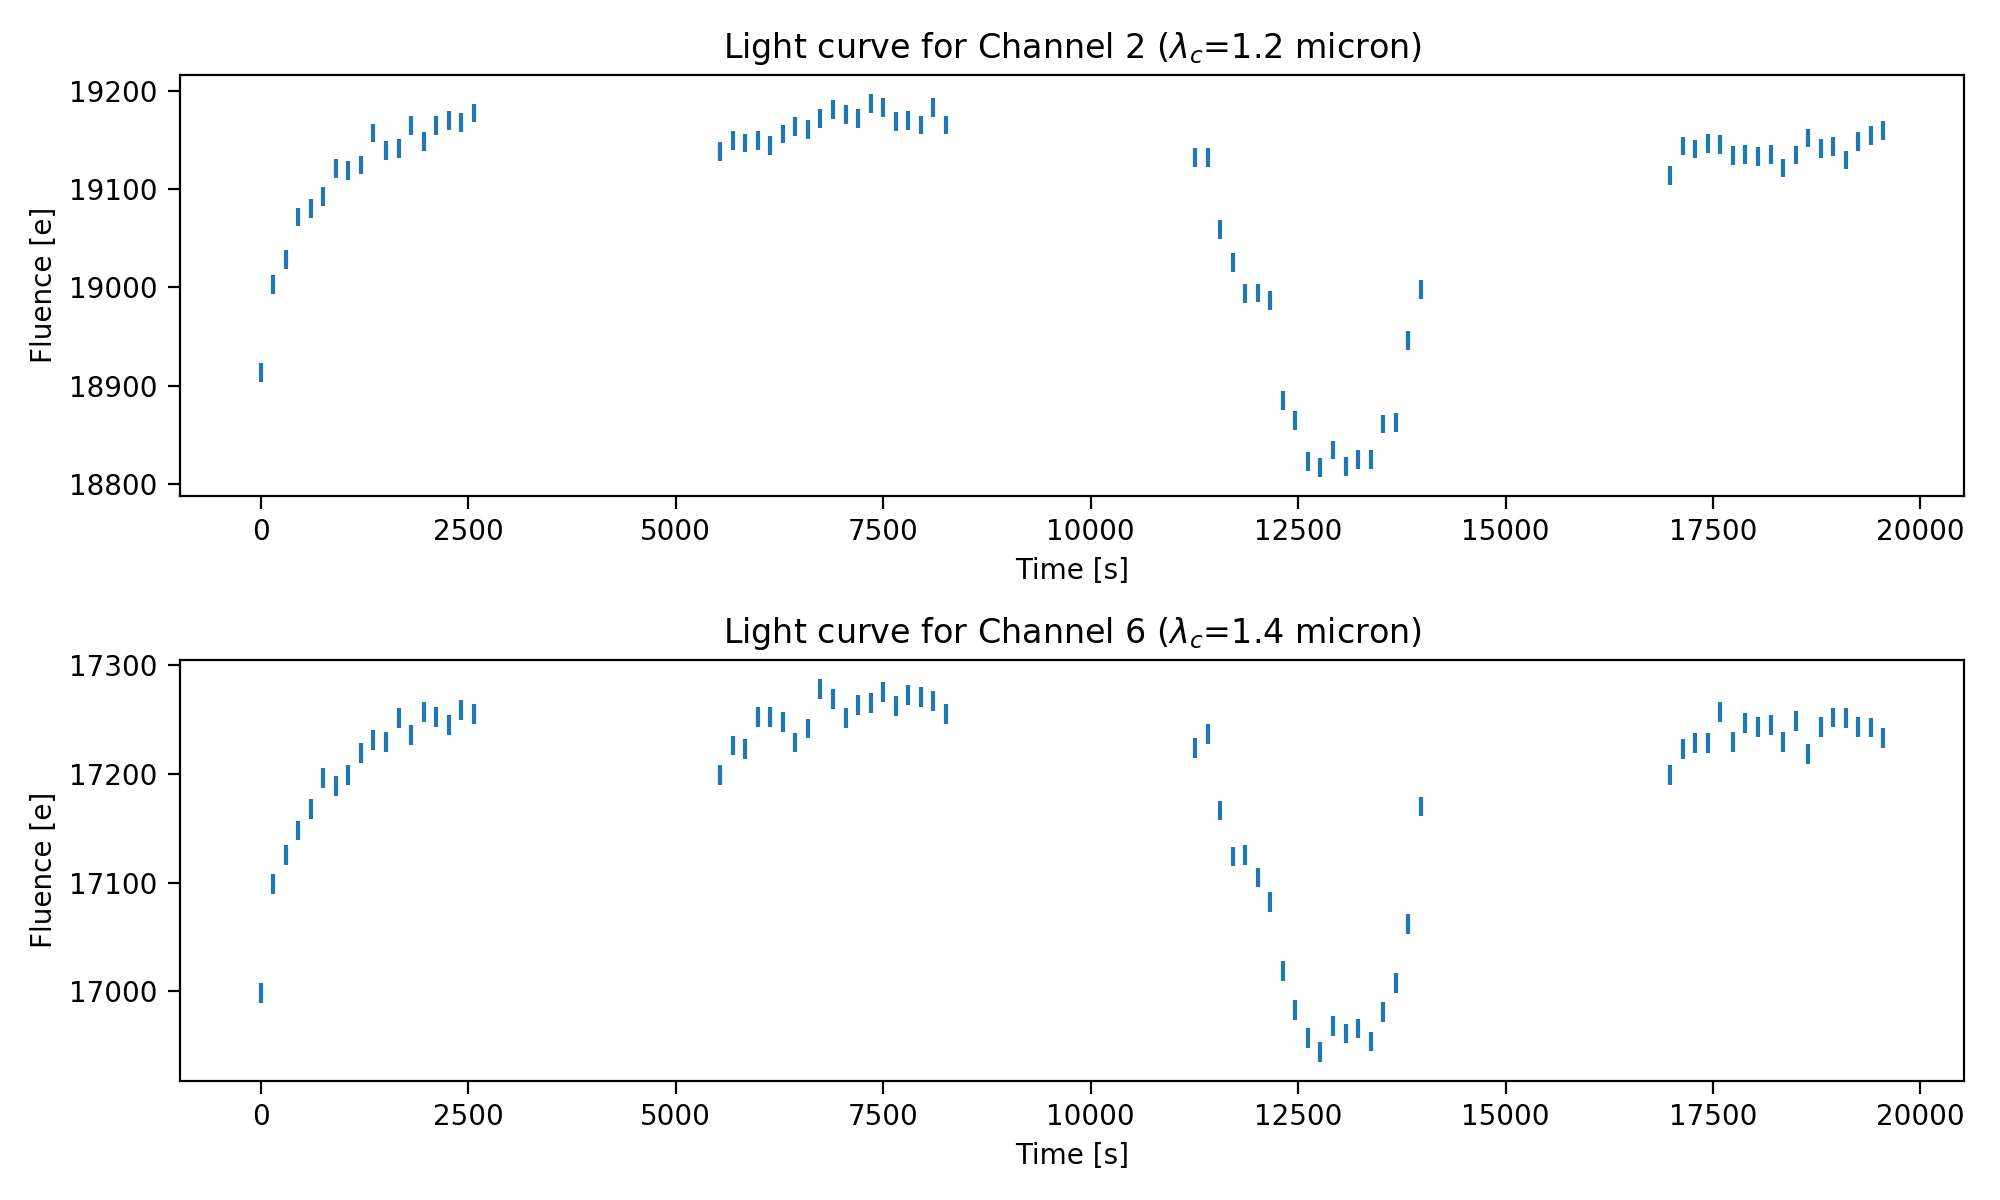

In [6]:
# plot light curve of the second channel and the sixth channel
fig1 = plt.figure(figsize=(10, 6))
ax1 = fig1.add_subplot(211)
ax1.errorbar(time, LCarray[1, :], yerr=ERRarray[1, :], ls='none')
ax1.set_title('Light curve for Channel 2 ($\lambda_c$={0:.2} micron)'.format(wavelength[1]))
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Fluence [e]')
ax2 = fig1.add_subplot(212)
ax2.errorbar(time, LCarray[5, :], yerr=ERRarray[5, :], ls='none')
ax2.set_title('Light curve for Channel 6 ($\lambda_c$={0:.2} micron)'.format(wavelength[6]))
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Fluence [e]')
fig1.tight_layout()

# RECTE corrections
We will use the convenience functions from the `RECTECorrector` module to make corrections. Two functions `RECTECorrrector1` and `RECTECorrector2` are for corrections for single-directional scanning or "round-trip" scanning observations, respectively. The observation used in this demonstration was done using "round-trip" scanning mode. Therefore, we use `RECTECorrector2` function to make the correction.

`RECTECorrector2` function fits RECTE model profiles to the observed light curves. It uses `lmfit` to perform the optimization. It excludes the orbits where transits/eclipses occur. But this function can be easily combined with transit model (such as `batman`) to include orbits of transits/eclipses in fitting calculations. `lmfit` can also be changed by MCMC sampler (such as `emcee`) to return more informative fitting results.

In the following, we write a wrapper function `removeRamp` to get the systematics-removed light curves

In [7]:
from RECTE import RECTE
from lmfit import Parameters, Model
from RECTECorrector import RECTECorrector2

def removeRamp(p0,
               time,
               LCArray,
               ErrArray,
               orbits,
               orbits_transit,
               expTime,
               scanDirect):
    """
    remove Ramp systemetics with RECTE
    
    :param p0: initial parameters
    :param time: time stamp of each exposure
    :param LCArray: numpy array that stores all light curves
    :param ErrArray: light curve uncertainties
    :param orbits: orbit number for each exposure
    :param orbits_transit: orbit number that transits occur. These orbits 
    are excluded in the fit
    :param expTime: exposure time
    :param scanDirect: scanning direction for each exposure. 0 for forward, 
    1 for backward
    """
    nLC = LCArray.shape[0]  # number of light curves
    correctedArray = LCArray.copy()
    correctedErrArray = ErrArray.copy()
    modelArray = LCArray.copy()
    crateArray = LCArray.copy()
    slopeArray = LCArray.copy()
    p = p0.copy()
    for i in range(nLC):
        correctTerm, crate, bestfit, slope = RECTECorrector2(
            time, 
            orbits, 
            orbits_transit, 
            LCArray[i, :], 
            p, 
            expTime, 
            scanDirect)
        # corrected light curve/error are normalized to the baseline
        correctedArray[i, :] = LCArray[i, :] / correctTerm / (crate)
        correctedErrArray[i, :] = ErrArray[i, :] / correctTerm / (crate)
        modelArray[i, :] = bestfit
        crateArray[i, :] = crate
        slopeArray[i, :] = slope
    return correctedArray, correctedErrArray, modelArray, crateArray, slopeArray

In [8]:
import pandas as pd
import numpy as np

infoFN = './demonstration_data/TRAPPIST_Info.csv'
info = pd.read_csv(infoFN)
grismInfo = info[info['Filter'] == 'G141']
scanDirect = grismInfo['ScanDirection'].values
p = Parameters()
p.add('trap_pop_s', value=0, min=0, max=200, vary=True)
p.add('trap_pop_f', value=0, min=0, max=100, vary=True)
p.add('dTrap_f', value=0, min=0, max=200, vary=True)
p.add('dTrap_s', value=50, min=0, max=100, vary=True)
LCarray_noRamp, ERRarray_noRamp, Modelarray, cratearray, slopearray = removeRamp(
    p, 
    time, 
    LCarray, 
    ERRarray, 
    orbit, 
    orbit_transit,
    expTime,
    scanDirect)

Now, ramp systemetics are removed from the observations.

## Result plot
### Best-fit Models

<IPython.core.display.Javascript object>


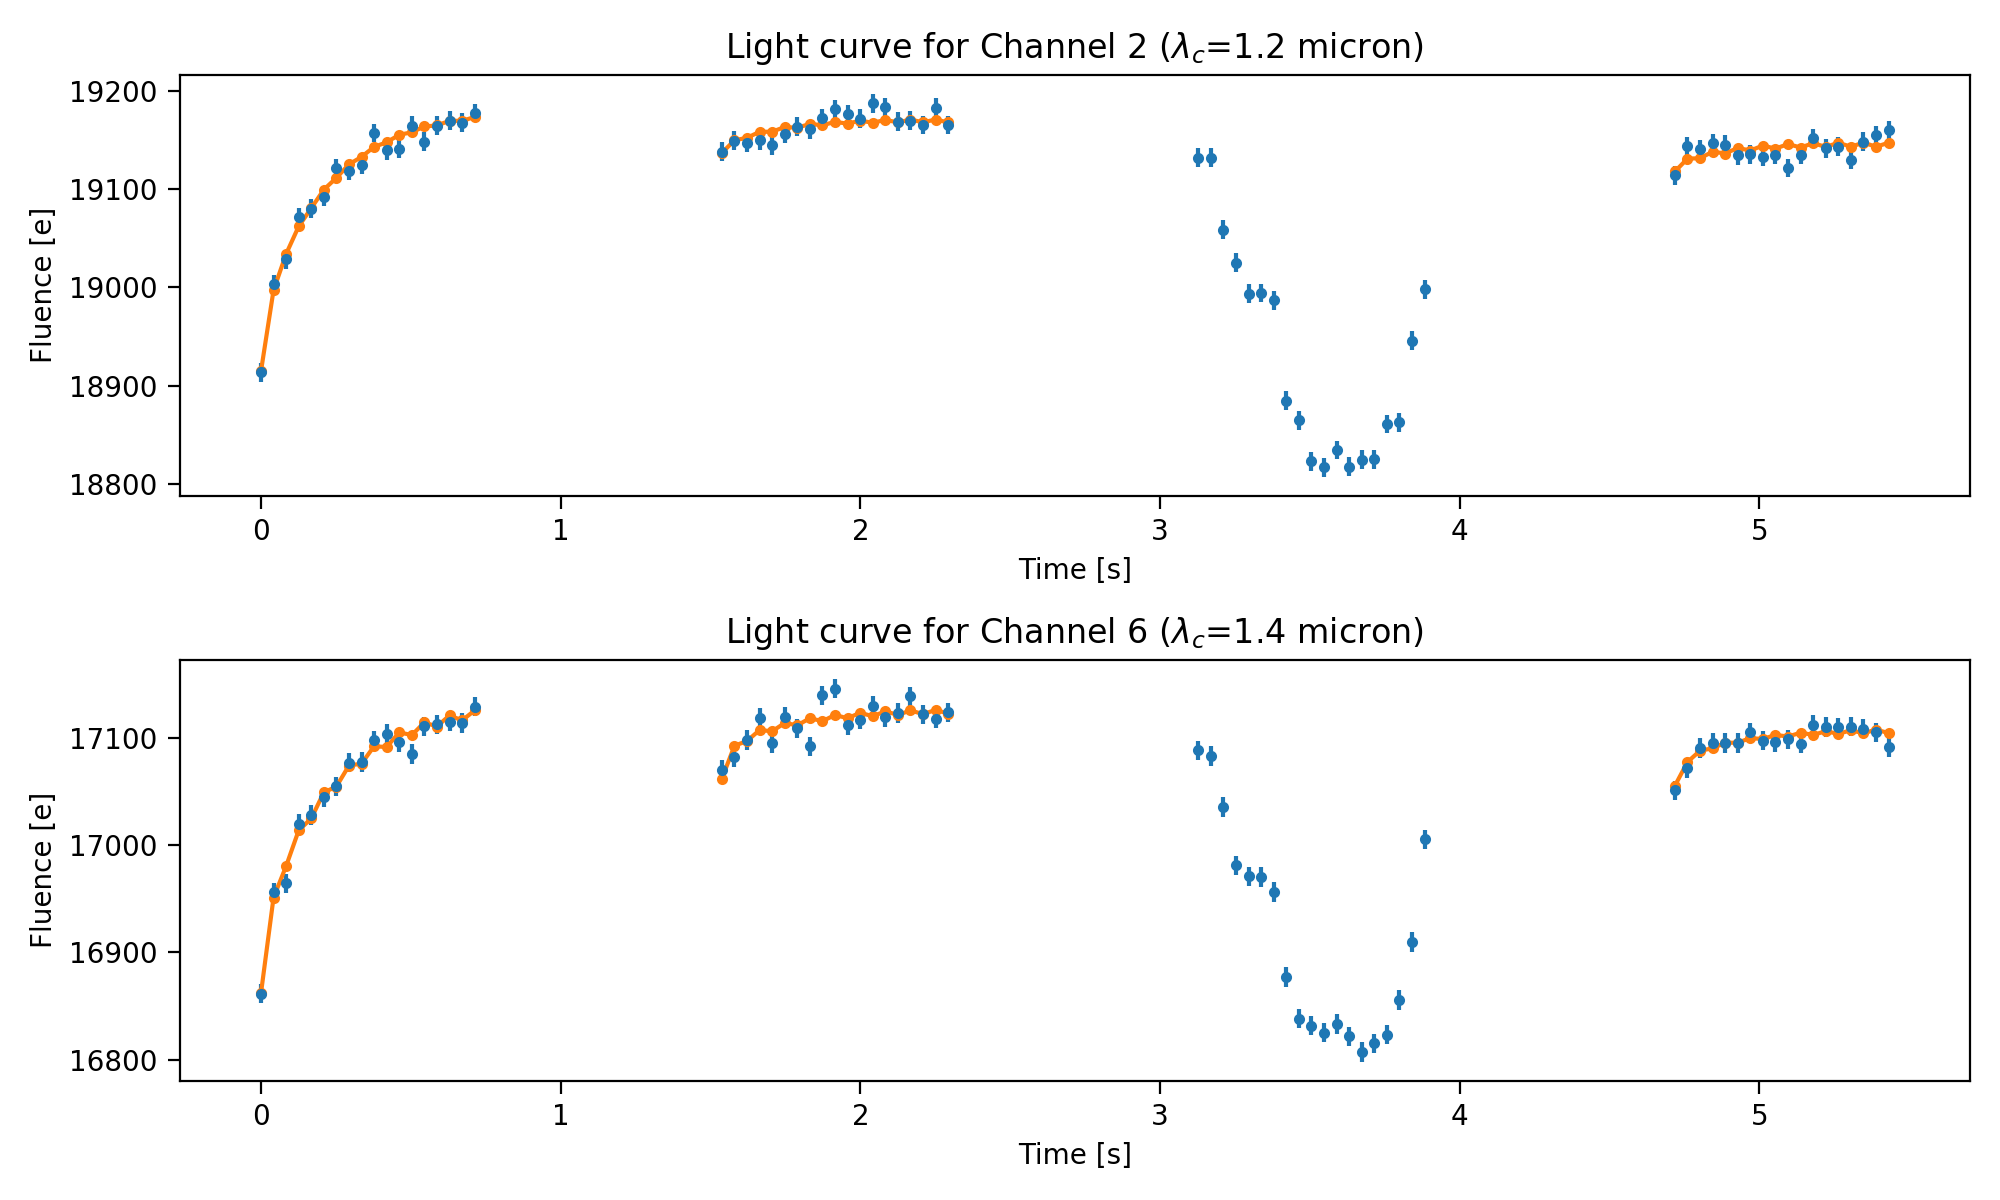

In [9]:
fig2 = plt.figure(figsize=(10, 6))
ax1 = fig2.add_subplot(211)

ax1.errorbar(
    time / 3600,
    LCarray[1, :],
    yerr=ERRarray[1, :],
    fmt='.',
    ls='')
for o in [0, 1, 3]:
    ax1.plot(
        time[orbit == o] / 3600,
        Modelarray[1, orbit == o],
        '.-',
        color='C1')
ax1.set_title('Light curve for Channel 2 ($\lambda_c$={0:.2} micron)'.format(wavelength[1]))
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Fluence [e]')

ax2 = fig2.add_subplot(212)
ax2.errorbar(
    time / 3600,
    LCarray[6, :],
    yerr=ERRarray[6, :],
    fmt='.',
    ls='')
for o in [0, 1, 3]:
    ax2.plot(
        time[orbit == o] / 3600,
        Modelarray[6, orbit == o],
        '.-',
        color='C1')
ax2.set_title('Light curve for Channel 6 ($\lambda_c$={0:.2} micron)'.format(wavelength[6]))
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Fluence [e]')
fig2.tight_layout()

### Corrected light curves

<IPython.core.display.Javascript object>


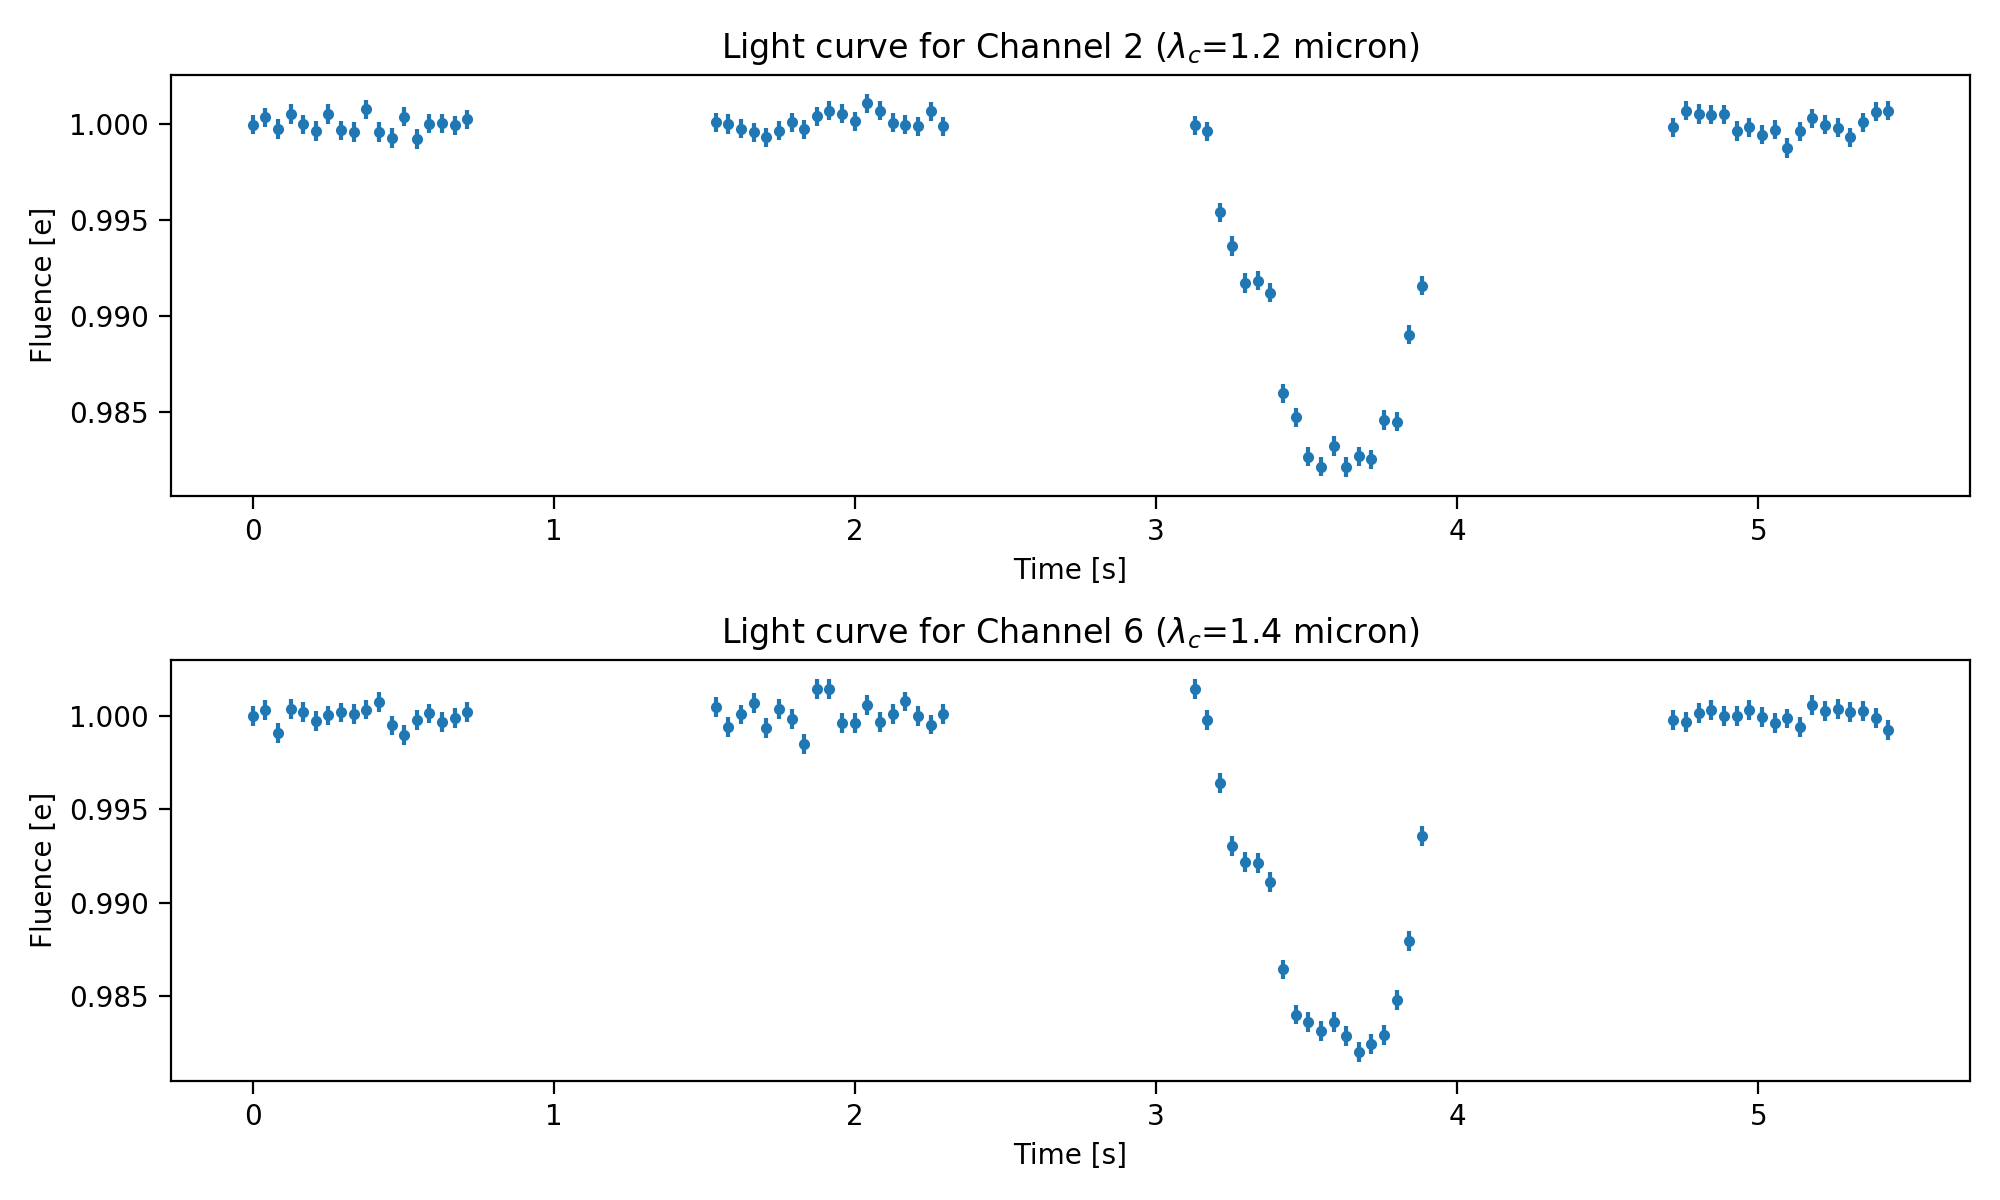

In [10]:
fig3 = plt.figure(figsize=(10, 6))
ax1 = fig3.add_subplot(211)

ax1.errorbar(
    time / 3600,
    LCarray_noRamp[1, :],
    yerr=ERRarray_noRamp[1, :],
    fmt='.',
    ls='')
ax1.set_title('Light curve for Channel 2 ($\lambda_c$={0:.2} micron)'.format(wavelength[1]))
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Fluence [e]')

ax2 = fig3.add_subplot(212)
ax2.errorbar(
    time / 3600,
    LCarray_noRamp[6, :],
    yerr=ERRarray_noRamp[6, :],
    fmt='.',
    ls='')

ax2.set_title('Light curve for Channel 6 ($\lambda_c$={0:.2} micron)'.format(wavelength[6]))
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Fluence [e]')
fig3.tight_layout()